# 测试一下服务器是否搭建成功

In [1]:
import openai

# openai的api_key为任意字符串
openai.api_key = "EMPTY"
# openai的调用接口
openai.base_url = 'http://127.0.0.1:6006/v1/'
# 此处使用一个公网ip加以说明(自搭建的condgen服务器)
# openai.base_url = "https://u282259-b26f-4a7d0b2a.westc.gpuhub.com:8443/v1/"

# 需要调用的模型
model = "Mixtral-8x7B-Instruct-v0.1"
# 对应的提示
prompt = "write a main function for python"

# 创建completion
completion = openai.completions.create(model=model, prompt=prompt)
# 结果
print(completion.choices[0].text)


Sure, here's a simple example of a main function in Python:


# 1. import

In [2]:
import os
import pybullet
import pybullet_data
import numpy as np
import threading
import copy
from openai import OpenAI
import cv2
from moviepy.editor import ImageSequenceClip
import shapely
import shapely
import ast
import astunparse
from time import sleep
from shapely.geometry import *
from shapely.affinity import *
from openai import RateLimitError, APIConnectionError
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import TerminalFormatter
from google.colab.patches import cv2_imshow

pybullet build time: Apr 30 2024 01:35:48


# 2. 构建OpenAI调用接口

In [3]:
clientOpenAI = OpenAI(api_key= openai.api_key,base_url=openai.base_url)

# 3. 下载ur5e机械臂资源

In [4]:
if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip

# 4. 导入需要的类

In [5]:
from LMP import LMP,LMPFGen
from LMP_wrapper import LMP_wrapper
import Prompts
import Config

# 5. 定义 PyBullet-based 环境 带有一个 UR5e 机械臂 和 夹持器

In [6]:
COLORS = {
    'blue':   (78/255,  121/255, 167/255, 255/255),
    'red':    (255/255,  87/255,  89/255, 255/255),
    'green':  (89/255,  169/255,  79/255, 255/255),
    'orange': (242/255, 142/255,  43/255, 255/255),
    'yellow': (237/255, 201/255,  72/255, 255/255),
    'purple': (176/255, 122/255, 161/255, 255/255),
    'pink':   (255/255, 157/255, 167/255, 255/255),
    'cyan':   (118/255, 183/255, 178/255, 255/255),
    'brown':  (156/255, 117/255,  95/255, 255/255),
    'gray':   (186/255, 176/255, 172/255, 255/255),
}

CORNER_POS = {
  'top left corner':     (-0.3 + 0.05, -0.2 - 0.05, 0),
  'top side':            (0,           -0.2 - 0.05, 0),
  'top right corner':    (0.3 - 0.05,  -0.2 - 0.05, 0),
  'left side':           (-0.3 + 0.05, -0.5,        0),
  'middle':              (0,           -0.5,        0),
  'right side':          (0.3 - 0.05,  -0.5,        0),
  'bottom left corner':  (-0.3 + 0.05, -0.8 + 0.05, 0),
  'bottom side':         (0,           -0.8 + 0.05, 0),
  'bottom right corner': (0.3 - 0.05,  -0.8 + 0.05, 0),
}

ALL_BLOCKS = ['blue block', 'red block', 'green block', 'orange block', 'yellow block', 'purple block', 'pink block', 'cyan block', 'brown block', 'gray block']
ALL_BOWLS = ['blue bowl', 'red bowl', 'green bowl', 'orange bowl', 'yellow bowl', 'purple bowl', 'pink bowl', 'cyan bowl', 'brown bowl', 'gray bowl']

PIXEL_SIZE = 0.00267857
BOUNDS = np.float32([[-0.3, 0.3], [-0.8, -0.2], [0, 0.15]]) 

In [7]:
# 夹持器代码 (Robotiq 2F85)

class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = 'robotiq_2f_85/robotiq_2f_85.urdf'
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool.
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while True:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  def check_grasp(self):
    while self.moving():
      sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist

  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

In [8]:
# 环境封装类

class PickPlaceEnv():

  def __init__(self, render=False, high_res=False, high_frame_rate=False):
    self.dt = 1/480
    self.sim_step = 0

    # Configure and start PyBullet.
    # python3 -m pybullet_utils.runServer
    # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
    pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
    pybullet.setPhysicsEngineParameter(enableFileCaching=0)
    assets_path = os.path.dirname(os.path.abspath(""))
    pybullet.setAdditionalSearchPath(assets_path)
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setTimeStep(self.dt)

    self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
    self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
    self.ee_link_id = 9  # Link ID of UR5 end effector.
    self.tip_link_id = 10  # Link ID of gripper finger tips.
    self.gripper = None

    self.render = render
    self.high_res = high_res
    self.high_frame_rate = high_frame_rate

  def reset(self, object_list):
    pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
    pybullet.setGravity(0, 0, -9.8)
    self.cache_video = []

    # Temporarily disable rendering to load URDFs faster.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

    # Add robot.
    pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
    self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
    self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
    self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

    # Move robot to home configuration.
    for i in range(len(self.joint_ids)):
      pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

    # Add gripper.
    if self.gripper is not None:
      while self.gripper.constraints_thread.is_alive():
        self.constraints_thread_active = False
    self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
    self.gripper.release()

    # Add workspace.
    plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
    pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

    # Load objects according to config.
    self.object_list = object_list
    self.obj_name_to_id = {}
    obj_xyz = np.zeros((0, 3))
    for obj_name in object_list:
      if ('block' in obj_name) or ('bowl' in obj_name):

        # Get random position 15cm+ from other objects.
        while True:
          rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
          rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
          rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
          if len(obj_xyz) == 0:
            obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
            break
          else:
            nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
            if nn_dist > 0.15:
              obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
              break
        
        object_color = COLORS[obj_name.split(' ')[0]]
        object_type = obj_name.split(' ')[1]
        object_position = rand_xyz.squeeze()
        if object_type == 'block':
          object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
        elif object_type == 'bowl':
          object_position[2] = 0
          object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
        pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
        self.obj_name_to_id[obj_name] = object_id
    

    # Re-enable rendering.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

    for _ in range(200):
      pybullet.stepSimulation()

    # record object positions at reset
    self.init_pos = {name: self.get_obj_pos(name) for name in object_list}

    return self.get_observation()

  def servoj(self, joints):
    """Move to target joint positions with position control."""
    pybullet.setJointMotorControlArray(
      bodyIndex=self.robot_id,
      jointIndices=self.joint_ids,
      controlMode=pybullet.POSITION_CONTROL,
      targetPositions=joints,
      positionGains=[0.01]*6)
  
  def movep(self, position):
    """Move to target end effector position."""
    joints = pybullet.calculateInverseKinematics(
        bodyUniqueId=self.robot_id,
        endEffectorLinkIndex=self.tip_link_id,
        targetPosition=position,
        targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
        maxNumIterations=100)
    self.servoj(joints)

  def get_ee_pos(self):
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    return ee_xyz

  def step(self, action=None):
    """Do pick and place motion primitive."""
    pick_pos, place_pos = action['pick'].copy(), action['place'].copy()

    # Set fixed primitive z-heights.
    hover_xyz = np.float32([pick_pos[0], pick_pos[1], 0.2])
    if pick_pos.shape[-1] == 2:
      pick_xyz = np.append(pick_pos, 0.025)
    else:
      pick_xyz = pick_pos
      pick_xyz[2] = 0.025
    if place_pos.shape[-1] == 2:
      place_xyz = np.append(place_pos, 0.15)
    else:
      place_xyz = place_pos
      place_xyz[2] = 0.15

    # Move to object.
    ee_xyz = self.get_ee_pos()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    while np.linalg.norm(pick_xyz - ee_xyz) > 0.01:
      self.movep(pick_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    # Pick up object.
    self.gripper.activate()
    for _ in range(240):
      self.step_sim_and_render()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()
    
    for _ in range(50):
      self.step_sim_and_render()
    
    # Move to place location.
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    # Place down object.
    while (not self.gripper.detect_contact()) and (place_xyz[2] > 0.03):
      place_xyz[2] -= 0.001
      self.movep(place_xyz)
      for _ in range(3):
        self.step_sim_and_render()
    self.gripper.release()
    for _ in range(240):
      self.step_sim_and_render()
    place_xyz[2] = 0.2
    ee_xyz = self.get_ee_pos()
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()
    place_xyz = np.float32([0, -0.5, 0.2])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    observation = self.get_observation()
    reward = self.get_reward()
    done = False
    info = {}
    return observation, reward, done, info

  def set_alpha_transparency(self, alpha: float) -> None:
    for id in range(20):
      visual_shape_data = pybullet.getVisualShapeData(id)
      for i in range(len(visual_shape_data)):
        object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
        rgba_color = list(rgba_color[0:3]) +  [alpha]
        pybullet.changeVisualShape(
            self.robot_id, linkIndex=i, rgbaColor=rgba_color)      
        pybullet.changeVisualShape(
            self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

  def step_sim_and_render(self):
    pybullet.stepSimulation()
    self.sim_step += 1

    interval = 40 if self.high_frame_rate else 60
    # Render current image at 8 FPS.
    if self.sim_step % interval == 0 and self.render:
      self.cache_video.append(self.get_camera_image())

  def get_camera_image(self):
    if not self.high_res:
      image_size = (240, 240)
      intrinsics = (120., 0, 120., 0, 120., 120., 0, 0, 1)
    else:
      image_size=(360, 360)
      intrinsics=(180., 0, 180., 0, 180., 180., 0, 0, 1)
    color, _, _, _, _ = env.render_image(image_size, intrinsics)
    return color

  def get_reward(self):
    return None

  def get_observation(self):
    observation = {}

    # Render current image.
    color, depth, position, orientation, intrinsics = self.render_image()

    # Get heightmaps and colormaps.
    points = self.get_pointcloud(depth, intrinsics)
    position = np.float32(position).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotation = np.float32(rotation).reshape(3, 3)
    transform = np.eye(4)
    transform[:3, :] = np.hstack((rotation, position))
    points = self.transform_pointcloud(points, transform)
    heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

    observation["image"] = colormap
    observation["xyzmap"] = xyzmap

    return observation

  def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):

    # Camera parameters.
    position = (0, -0.85, 0.4)
    orientation = (np.pi / 4 + np.pi / 48, np.pi, np.pi)
    orientation = pybullet.getQuaternionFromEuler(orientation)
    zrange = (0.01, 10.)
    noise=True

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def get_pointcloud(self, depth, intrinsics):
    """Get 3D pointcloud from perspective depth image.
    Args:
      depth: HxW float array of perspective depth in meters.
      intrinsics: 3x3 float array of camera intrinsics matrix.
    Returns:
      points: HxWx3 float array of 3D points in camera coordinates.
    """
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

  def transform_pointcloud(self, points, transform):
    """Apply rigid transformation to 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in camera coordinates.
      transform: 4x4 float array representing a rigid transformation matrix.
    Returns:
      points: HxWx3 float array of transformed 3D points.
    """
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            'constant', constant_values=1)
    for i in range(3):
      points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

  def get_heightmap(self, points, colors, bounds, pixel_size):
    """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in world coordinates.
      colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
      bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
        region in 3D space to generate heightmap in world coordinates.
      pixel_size: float defining size of each pixel in meters.
    Returns:
      heightmap: HxW float array of height (from lower z-bound) in meters.
      colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
      xyzmap: HxWx3 float array of XYZ points in world coordinates.
    """
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
    xyzmap = np.zeros((height, width, 3), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
    valid = ix & iy & iz
    points = points[valid]
    colors = colors[valid]

    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points, colors = points[iz], colors[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    for c in range(colors.shape[-1]):
      colormap[py, px, c] = colors[:, c]
      xyzmap[py, px, c] = points[:, c]
    colormap = colormap[::-1, :, :]  # Flip up-down.
    xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                         np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
    xyzmap[:, :, 0] = xv
    xyzmap[:, :, 1] = yv
    xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
    heightmap = heightmap[::-1, :]  # Flip up-down.
    return heightmap, colormap, xyzmap
  
  def on_top_of(self, obj_a, obj_b):
    """
    check if obj_a is on top of obj_b
    condition 1: l2 distance on xy plane is less than a threshold
    condition 2: obj_a is higher than obj_b
    """
    obj_a_pos = self.get_obj_pos(obj_a)
    obj_b_pos = self.get_obj_pos(obj_b)
    xy_dist = np.linalg.norm(obj_a_pos[:2] - obj_b_pos[:2])
    if obj_b in CORNER_POS:
      is_near = xy_dist < 0.06
      return is_near
    elif 'bowl' in obj_b:
      is_near = xy_dist < 0.06
      is_higher = obj_a_pos[2] > obj_b_pos[2]
      return is_near and is_higher
    else:
      is_near = xy_dist < 0.04
      is_higher = obj_a_pos[2] > obj_b_pos[2]
      return is_near and is_higher
  
  def get_obj_id(self, obj_name):
    try:
      if obj_name in self.obj_name_to_id:
        obj_id = self.obj_name_to_id[obj_name]
      else:
        obj_name = obj_name.replace('circle', 'bowl').replace('square', 'block').replace('small', '').strip()
        obj_id = self.obj_name_to_id[obj_name]
    except:
      print(f'requested_name="{obj_name}"')
      print(f'available_objects_and_id="{self.obj_name_to_id}')
    return obj_id
  
  def get_obj_pos(self, obj_name):
    obj_name = obj_name.replace('the', '').replace('_', ' ').strip()
    if obj_name in CORNER_POS:
      position = np.float32(np.array(CORNER_POS[obj_name]))
    else:
      pick_id = self.get_obj_id(obj_name)
      pose = pybullet.getBasePositionAndOrientation(pick_id)
      position = np.float32(pose[0])
    return position
  
  def get_bounding_box(self, obj_name):
    obj_id = self.get_obj_id(obj_name)
    return pybullet.getAABB(obj_id)

# 6. 定义LMP设置函数

In [9]:
def setup_LMP(env, cfg_tabletop):
  # LMP env wrapper
  cfg_tabletop = copy.deepcopy(cfg_tabletop)
  cfg_tabletop['env'] = dict()
  cfg_tabletop['env']['init_objs'] = list(env.obj_name_to_id.keys())
  cfg_tabletop['env']['coords'] = Config.lmp_tabletop_coords
  LMP_env = LMP_wrapper(env, cfg_tabletop)
  # creating APIs that the LMPs can interact with
  fixed_vars = {
      'np': np
  }
  fixed_vars.update({
      name: eval(name)
      for name in shapely.geometry.__all__ + shapely.affinity.__all__
  })
  variable_vars = {
      k: getattr(LMP_env, k)
      for k in [
          'get_bbox', 'get_obj_pos', 'get_color', 'is_obj_visible', 'denormalize_xy',
          'put_first_on_second', 'get_obj_names',
          'get_corner_name', 'get_side_name',
      ]
  }
  variable_vars['say'] = lambda msg: print(f'robot says: {msg}')

  # creating the function-generating LMP
  lmp_fgen = LMPFGen(cfg_tabletop['lmps']['fgen'], fixed_vars, variable_vars,clientOpenAI)

  # creating other low-level LMPs
  variable_vars.update({
      k: LMP(k, cfg_tabletop['lmps'][k], lmp_fgen, fixed_vars, variable_vars,clientOpenAI)
      for k in ['parse_obj_name', 'parse_position', 'parse_question', 'transform_shape_pts']
  })

  # creating the LMP that deals w/ high-level language commands
  lmp_tabletop_ui = LMP(
      'tabletop_ui', cfg_tabletop['lmps']['tabletop_ui'], lmp_fgen, fixed_vars, variable_vars,clientOpenAI
  )

  return lmp_tabletop_ui

# 7. 初始化仿真环境

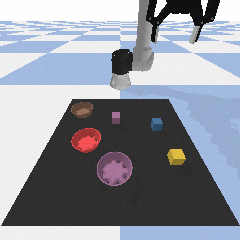

available objects:
['yellow block', 'blue block', 'purple block', 'red bowl', 'brown bowl', 'purple bowl']


In [10]:
#@title Initialize Env { vertical-output: true }
num_blocks = 3 #@param {type:"slider", min:0, max:4, step:1}
num_bowls = 3 #@param {type:"slider", min:0, max:4, step:1}
high_resolution = False #@param {type:"boolean"}
high_frame_rate = False #@param {type:"boolean"}

# setup env and LMP
env = PickPlaceEnv(render=True, high_res=high_resolution, high_frame_rate=high_frame_rate)
block_list = np.random.choice(ALL_BLOCKS, size=num_blocks, replace=False).tolist()
bowl_list = np.random.choice(ALL_BOWLS, size=num_bowls, replace=False).tolist()
obj_list = block_list + bowl_list
_ = env.reset(obj_list)
lmp_tabletop_ui = setup_LMP(env, Config.cfg_tabletop)

# display env
cv2_imshow(cv2.cvtColor(env.get_camera_image(), cv2.COLOR_BGR2RGB))

print('available objects:')
print(obj_list)

# 8.调用LLM，获取机械手移动策略

In [11]:
user_input =  'Stack all blocks'##'将橙色的块放在最右边的碗的左边'

env.cache_video = []

print('运行策略并，录制视频...')
lmp_tabletop_ui(user_input, f'objects = {env.object_list}')

# render video
if env.cache_video:
  rendered_clip = ImageSequenceClip(env.cache_video, fps=35 if high_frame_rate else 25)
  display(rendered_clip.ipython_display(autoplay=1, loop=1))

运行策略并，录制视频...
say("Stacking all blocks")
stack_objects_in_order(object_names=['purple block', 'blue block', 'yellow block'])
LMP tabletop_ui exec:

objects = ['yellow block', 'blue block', 'purple block', 'red bowl', 'brown bowl', 'purple bowl']
# Stack all blocks.
say("Stacking all blocks")
stack_objects_in_order(object_names=['purple block', 'blue block', 'yellow block'])


Creating function: stack_objects_in_order(object_names=['purple block', 'blue block', 'yellow block'])
LMP FGEN created:

# define function: stack_objects_in_order(object_names=['purple block', 'blue block', 'yellow block']).
def stack_objects_in_order(object_names):
    for i in range(len(object_names) - 1):
        put_first_on_second(object_names[i + 1], object_names[i])


robot says: Stacking all blocks


100%|██████████████████████████████████████████████████████████████████████| 84/84 [00:03<00:00, 27.06it/s]
